In [20]:
# import sys
# !{sys.executable} -m pip install networkx matplotlib
import networkx as nx
import matplotlib.pyplot as plt
import random
import copy

def assign_random_orientation(graph: nx.Graph): # also works with MultiGraph 
    for edge in graph.edges(data=True):
        this_vertex, other_end, data = edge
        data['start'] = random.choice([this_vertex, other_end])
    
def invert_generator(generator):
    return generator.upper() if not str.isupper(generator) else generator.lower()

a = ord('a')
def get_generator_names(K: int):
    return [ chr( a + i ) for i in range(K) ]

def assign_random_generators(graph: nx.Graph, generator_names):
    S = set(generator_names)
    SuSinv =  S.union( set( [ s.upper() for s in S ] ) )
    def randomGenerator(blocked_generators):
        return random.choice( list( SuSinv.difference(blocked_generators) ) )
    def assigned_outgoing_generators_at_vertex(vertex): 
        return set( [
            data['generator'] if data['start'] == vertex else invert_generator(data['generator'])
            for *_, data in graph.edges(vertex, data=True) 
            if 'generator' in data] 
        )
    
    for i in range(RETRIES := 10):
        for vertex in graph.nodes:
            assigned_generators = assigned_outgoing_generators_at_vertex(vertex)
            
            for edge in graph.edges(vertex, data=True):
                origin, target, data = edge
                # context: this_vertex, other_end, key, data = edge (omit key, needs actual MultiGraph)
                if 'generator' in data:
                    continue
                
                assigned_generators_at_target = [ invert_generator(g) for g in assigned_outgoing_generators_at_vertex(target) ]
                blocked_generators = assigned_generators.union(assigned_generators_at_target) if i < RETRIES - 1 else assigned_generators
                if len(blocked_generators) == len(SuSinv):
                    print("Warning: All generators are blocked at edge", edge)
                    break # break two loops (clever try/else XD)

                random_generator = randomGenerator(blocked_generators)
                
                assigned_generators.add(random_generator)
                data['generator'] = random_generator
            else: # all went well
                continue
            break # an edge was not assigned a generator
        else: # all went well
            break
        if i == RETRIES - 2:
            print("Warning: Could not assign all generators, will now ignore remote blocked generators")
        continue # at a vertex an edge was not assigned a generator
    else:
        print("Warning: Could not assign all generators") # should not happen. In the last retry, we don't look at remote blocked generators


def draw_graph(G):
    edge_labels = nx.get_edge_attributes(G,'generator')
    pos=nx.spring_layout(G, k=0.5),
    if len(pos) == 1:
        print(pos)
        pos = pos[0]
    nx.draw(G, pos=pos, with_labels=False, alpha=0.7)
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels = edge_labels)
    plt.show()

def addReverseEdges(graph: nx.Graph):
    dir_graph = graph.to_directed()
    for edge in dir_graph.edges(data=True):
        this_vertex, other_end, data = edge
        if data['start'] != this_vertex:
            data['generator'] = invert_generator(data['generator'])
    return dir_graph

def removeReverseEdges(dir_graph: nx.DiGraph):
    oriented_graph = copy.deepcopy(dir_graph)
    for edge in list(oriented_graph.edges(data=True)):
        this_vertex, other_end, data = edge
        # if data['start'] != this_vertex: # this would take the originial orientation which was random
        if data['generator'].isupper():
            oriented_graph.remove_edge(this_vertex, other_end)
    return oriented_graph


Wir erzeugen einen zufälligen Graphen (im Sinne der VL, d.h. oriented Multigraph, aber unoriented, d.h. mit edge reversal Funktion) mit "erwarteter Valenz" und dann eine zufällige Abbildung $ α: E \rightarrow S \cup S^{-1}, S =\{a,...,k\}$, sd. 
 $ α(\bar e) = α(e)^{-1}. $
 

In [21]:
def relators_from_graph(dir_graph: nx.DiGraph) -> list[str]:

    loops = list(nx.simple_cycles(dir_graph)) # Zykel, die keinen Vertex mehr als einmal besuchen. Sonst könnte man einen Subzykel nehmen

    relators = []
    for node_cycle in loops:
        l=len(node_cycle)
        if l == 2:
            continue # for non-multi-graphs, this gives the trivial relations aA
        edge_cycle = [dir_graph[ node_cycle[i] ][ node_cycle[i+1] if i+1 < l else node_cycle[0] ][ 'generator' ]  for i in range(l)] #(*)
        relators.append(''.join(edge_cycle))
    return relators

def relator_to_explicit_notation(relator: str):
    return '*'.join(x if str.islower(x) else x.lower() + '^(-1)' for x in relator)

# print(', '.join(relators))
# print(', '.join(relator_to_explicit_notation(relator) for relator in relators))



Wenn es ein Multigraph wäre (wie in der Vorlesung), müsste man bei (*) irgendwie einen key angeben (eine der parallelen Kanten auswählen). 

Es reicht aber, das für die Zykel von Länge zwei zu machen, danach ist es ja egal, welche Kante man nimmt, da z.b. a=b als Relation schon hinzugefügt wurde. 

Es sollte nicht zu viele solche Kanten geben. Ebenso sollte es keine Selbstkanten geben, da diese einfach nur die Relation a=1 ergeben würden.

Todo: Die Relatoren mit vorherigen Relatoren vereinfachen, und wenn unnötig, entfernen.

In [22]:
import re
from sympy.combinatorics.free_groups import *
from sympy.combinatorics.fp_groups import *
from sympy import Symbol
from functools import reduce

def init_free_group(generator_names):
    global F, generators
    F, *generators = free_group(generator_names)

def textToSympySymbol(x):
    assert str.isalpha(x) and len(x) == 1, "x must be a single letter"
    if str.isupper(x):
        return textToSympySymbol(x.lower())**-1
    return generators[ord(x) - a]

def toSympyRelation(relator):
    return reduce(lambda a, b: a * b, [textToSympySymbol(x) for x in relator], F.identity)

def print_group(generator_names, relators: list[str]):
    unneccessary_generators = [ g for g in generator_names if g in relators or g.upper() in relators]
    
    pattern = "[" + "".join(unneccessary_generators) + "]"
    def remove_unnecessary_letters(r):
        return re.sub(pattern, "", r, flags=re.IGNORECASE)
    reduced_relators = [ remove_unnecessary_letters(r) for r in relators ] if unneccessary_generators else relators
    print('<', ', '.join(set(generator_names).difference(unneccessary_generators)), ' | ', ', '.join(r for r in reduced_relators if len(r) >= 1), '>', sep='')

In [23]:
# !{sys.executable} -m pip install gappy-system
# from gappy import gap
# gap.IsomorphismSimplifiedFpGroup( G )

In [24]:
from sympy.combinatorics.free_groups import FreeGroupElement # wirft Error, wenn man import * macht !?!
from sympy.combinatorics.fp_groups import FpGroup # wirft Error, wenn man import * macht !?!

def reducedRelations(relations, reversed = False):
    res = []
    if reversed:
        relations.reverse()
    for r in relations:
        G = FpGroup(F, res)
        r_red: FreeGroupElement = G.reduce(r)
        if not r_red.is_identity:
            res.append( r_red )
            
    if reversed:
        res.reverse()
    return res

def sympySymbolToText(x: Symbol, pow = 1):
    if pow == 0:
        return ''
    if pow == 1:
        return x.name
    if pow > 1:
        # return x.name + '^' + str(pow)
        return x.name * pow
    return sympySymbolToText(x, -pow).upper()

def sympyRelationToText(relation: FreeGroupElement):
    return ''.join( sympySymbolToText(s, pow) for s, pow in relation.array_form )


In [25]:
from time import time
T = time()
def print_time():
    global T
    t = time()
    print(round(t - T, 2), end=': ')
    T = t

({0: array([0.34285339, 0.37291583]), 1: array([0.40915798, 0.92150463]), 2: array([-0.15988924, -0.17638333]), 3: array([-0.01564506,  0.45691003]), 4: array([ 0.05353332, -0.05886941]), 5: array([ 0.03694226, -0.61998552]), 6: array([0.13299941, 0.36181374]), 7: array([-0.43215649, -1.        ]), 8: array([-0.36779557, -0.25790596])},)


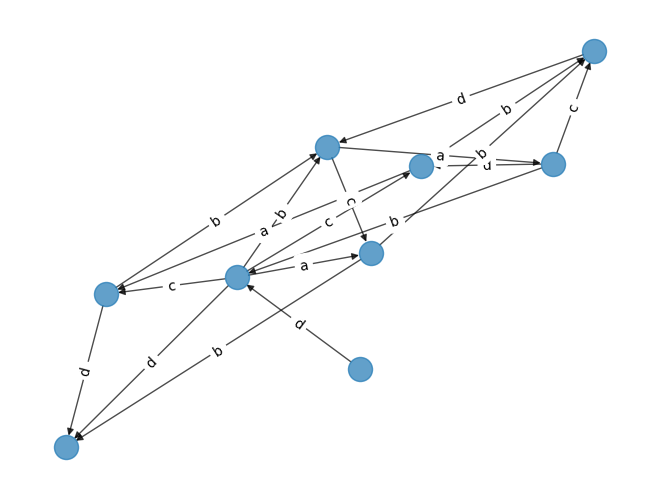

4.92: <a, b, d, c | cda, cdBB, cdBabDAD, cdBcD, cdBdDAD, cdBcAD, cdcAB, cdcAcD, cdcAdDAD, cdcAcAD, cdcbDB, cdcbDcD, cdcbDcAD, cdcbDCB, cdcbDCcD, cdcbDAD, cdcbDACB, cdBCB, cdBCcD, cdBAD, cdBACB, cdBdDB, cdBdDcD, cdBdBAB, cdBdBAcD, cBAB, cBAba, cBAbBAD, cBAcD, cBAcaba, cBAdDba, cBAdDAD, cBAcba, cBAcAD, cBCa, cBCBB, cBCBcD, cBCBdDAD, cBCBcAD, cBCBCB, cBCBCcD, cBCBAD, cBCBACB, cBCBdDB, cBCBdDcD, cBbDB, cBbDba, cBbDbBAD, cBbDcD, cBbDcaba, cBbDcba, cBbDcAD, cBbDCB, cBbDCba, cBbDCcD, cBbDba, cBbDbBB, cBbDbBcD, cBbDAD, cBbDACB, cBbDACba, cBD, cBCB, cBCba, cBCaCa, cBCabDba, cBCdBCa, cBCdDba, cBCcba, cBCcdBCa, cBaCB, cBaCba, cBaCaCa, cBaCdBCa, cBaba, cBabBB, cBabcAB, cBabcbDB, cBadDB, cBadDba, cBadDaCa, cBadBAB, cBadBAba, cBadBCa, cBadBCBB, bba, bbDC, bbDBbDAD, bbDBD, bbcbC, bbcbBD, bbcbDAD, bbcbDAbC, bbBAD, bbBAbC, bbBdBbC, bbBdBbBD, babC, babda, babdBAD, babBD, babBaba, baCa, baCDC, baCDBD, baCBAD, baCBAbC, babDba, babDbDC, babDbDBD, babDAD, babDAbC, babDAbda, bcD, bcbC, bcbda, bcbBCa, bcbBbDb

In [28]:
valency = [5,5,5,4,4,4,3,3,3]
graph = nx.expected_degree_graph(valency, selfloops=False) # selfloops: s.u.
degree = max([d for n,d in graph.degree]) # can be more than max(valency), bc of randomness

assign_random_orientation(graph)
# multi_graph = nx.MultiGraph( graph ) # s. Bem.

K = degree // 2 + degree % 2 # number of generators
generator_names = get_generator_names(K)
assign_random_generators(graph, generator_names)

dir_graph = addReverseEdges(graph)
oriented_graph = removeReverseEdges(dir_graph)

draw_graph(oriented_graph)

relators = relators_from_graph(dir_graph)
print_time()
print_group(generator_names, relators)


## reduce relations. First time takes a long time
init_free_group(generator_names)
relations = [toSympyRelation(relator) for relator in relators]
red_relations = relations
for i in range(3):
    red_relations = reducedRelations(red_relations, reversed = i % 2 == 1)
    print_time()
    print_group(generator_names, [ sympyRelationToText(r) for r in red_relations])

    
G = FpGroup(F, red_relations)
try:
    o = G.order()
    print_time()
    print("G has order", o)
except Exception as e:
    print_time()
    print(e)